## H$\alpha$ line fitting for the SALT spectra

In [531]:
#Define profiles to showcase similarity or dissimilarity
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def lorentz(x, mu, fwhm):
    X = (x - mu)/fwhm*2
    return 1/(1+X**2)

In [580]:
from eniric import broaden

from astropy.convolution import Gaussian1DKernel, convolve

In [294]:
import numpy as np
import pandas as pd

import matplotlib 
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)

import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.constants import R_sun, c
import astropy.units as u

from scipy import interpolate

from scipy.signal import correlate

import copy

In [608]:
from scipy.optimize import minimize


# Get spectra

In [433]:
dirr = "/home/ekaterina/Documents/001_science/MalachiteMountains/data"

# SALT spectra
sp1 = pd.read_csv(f"{dirr}/salt/R202002090014.1.ffc.hwl.txt", delimiter="\s+", names=["lambd","flux","flux_err"])
sp2 = pd.read_csv(f"{dirr}/salt/R202002080017.1.ffc.hwl.txt", delimiter="\s+", names=["lambd","flux","flux_err"])
sp3 = pd.read_csv(f"{dirr}/salt/R202002080014.1.ffc.hwl.txt", delimiter="\s+", names=["lambd","flux","flux_err"])

#CN Leonis

hdu = fits.open(f"{dirr}/carmenes/carmenes_cnleo_vis.fits")

lambd = hdu[4].data.flatten().byteswap().newbyteorder()
flux = hdu[1].data.flatten().byteswap().newbyteorder()
cnleo = pd.DataFrame({"lambd":lambd, "flux":flux}).sort_values(by="lambd", ascending=True)
cnleo = cnleo.dropna(how="any")
cnleo.lambd = cnleo.lambd - 2.8 # offset of spectrum


# Another Carmenes spectrum
stri = f"{dirr}/carmenes/carmenes_58kms_m5_vis.fits"
stri = f"{dirr}/carmenes/carmenes_m8_norot.fits"
stri = f"{dirr}/carmenes_teegarden_vis.fits"
hdu = fits.open(stri)
lambd = hdu[4].data.flatten().byteswap().newbyteorder()
flux = hdu[1].data.flatten().byteswap().newbyteorder()
carm = pd.DataFrame({"lambd":lambd, "flux":flux}).sort_values(by="lambd", ascending=True)
carm = carm.dropna(how="any")
carm.lambd = carm.lambd #- 2.5 # offset of spectrum

# Pick spectral regions

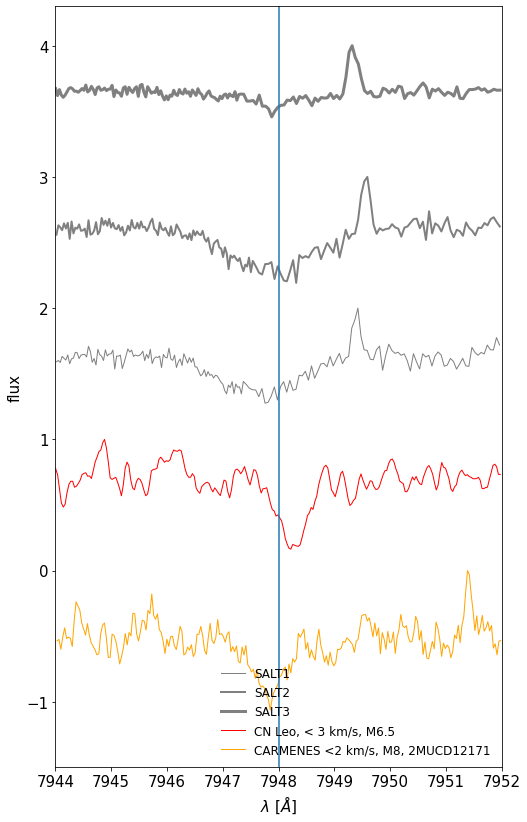

In [578]:
plt.figure(figsize=(8,14))

wavmin, wavmax = 7944, 7952#,6708, 6728,#8170,8200#7930, 7965#7670, 7730#6556, 6570.5

# Show the SALT spectra
for sp, l in [(sp1,"1"), (sp2,"2"), (sp3,"3")]:
    wav = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"lambd"].values
    mflux = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"flux"].values
    plt.plot(wav,mflux / np.max(mflux) + float(l),linewidth=float(l), c="grey", label="SALT" + l)

# Show CN Leo
sp44 = cnleo[(cnleo.lambd>wavmin) & (cnleo.lambd<wavmax)]
plt.plot(sp44.lambd, sp44.flux/sp44.flux.max(), 
              c="r", linewidth=1, label="CN Leo, < 3 km/s, M6.5")

# Chow the other Carmenes spectrum
sp44 = carm[(carm.lambd>wavmin) & (carm.lambd<wavmax)]
plt.plot(sp44.lambd, sp44.flux/sp44.flux.max()-1, 
              c="orange", linewidth=1, label="CARMENES <2 km/s, M8, 2MUCD12171")

## Optionally, come back here to overplot broadened spectra
# for col in specs:
#     plt.plot(specs.index, specs[col])

# # Plot line position if desired
# plt.axvline(7948)


# Layout
plt.xlim(wavmin, wavmax)
#plt.ylim(-100,1e5)
plt.xlabel(r"$\lambda$ [$\AA$]", fontsize=15)
plt.ylabel(r"flux", fontsize=15)
plt.ylim(-1.5,4.3)
plt.legend(fontsize=12, frameon=False)


#plt.savefig("../plots/vsini/Na_doublet_CARMENES.png", dpi=300)

# Rotational broadening

[see eniric docs](https://eniric.readthedocs.io/en/latest/broadening.html#rotational-broadening)

In [579]:
# Use CN Leo as a model spectrum
model=cnleo
wav = model.loc[(model.lambd>wavmin) & (model.lambd<wavmax),"lambd"].values 
mflux = model.loc[(model.lambd>wavmin) & (model.lambd<wavmax),"flux"].values
mflux = mflux / np.max(mflux)

In [581]:
# Choose vsini grid
vsinis = np.array(list(range(5,110,5)))# + list(range(30,110)))
vsinis

array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100, 105])

In [582]:
# Create a grid of broadened spectra
specs = pd.DataFrame({"wav":wav})

for vsini in vsinis:
    specs[vsini] = broaden.rotational_convolution(wav, model.lambd, model.flux, vsini)



100%|██████████| 241/241 [00:01<00:00, 151.88it/s]

100%|██████████| 241/241 [00:00<00:00, 516.16it/s]

100%|██████████| 241/241 [00:00<00:00, 514.36it/s]

100%|██████████| 241/241 [00:00<00:00, 574.70it/s]

100%|██████████| 241/241 [00:00<00:00, 604.48it/s]

100%|██████████| 241/241 [00:00<00:00, 547.34it/s]

100%|██████████| 241/241 [00:00<00:00, 464.22it/s]

100%|██████████| 241/241 [00:00<00:00, 512.45it/s]

100%|██████████| 241/241 [00:00<00:00, 496.44it/s]

100%|██████████| 241/241 [00:00<00:00, 516.27it/s]

100%|██████████| 241/241 [00:00<00:00, 474.01it/s]

100%|██████████| 241/241 [00:00<00:00, 516.05it/s]

100%|██████████| 241/241 [00:00<00:00, 502.34it/s]

100%|██████████| 241/241 [00:00<00:00, 531.28it/s]

100%|██████████| 241/241 [00:00<00:00, 526.60it/s]

100%|██████████| 241/241 [00:00<00:00, 475.69it/s]

100%|██████████| 241/241 [00:00<00:00, 488.73it/s]

100%|██████████| 241/241 [00:00<00:00, 505.00it/s]

100%|██████████| 241/241 [00:00<00:00, 456.33it/s]

100%|██████

In [583]:
# Save and/or read grid of broadened spectra
#specs.to_csv(f"../../data/eniric/{wavmin}_{wavmax}_cnleo.csv",index=False)
specs = pd.read_csv(f"../../data/eniric/{wavmin}_{wavmax}_cnleo.csv")
specs = specs.set_index("wav")
specs.head()

,5,10,15,20,25,30,35,40,45,50,...,60,65,70,75,80,85,90,95,100,105
wav,,,,,,,,,,,,,,,,,,,,,
7944.007355,0.032843,0.029606,0.029866,0.031035,0.032091,0.032788,0.033403,0.033737,0.033776,0.033735,...,0.033372,0.033150,0.033040,0.033024,0.033037,0.033063,0.033067,0.033009,0.032908,0.032797
7944.041049,0.031036,0.029544,0.029611,0.030735,0.031866,0.032732,0.033439,0.033755,0.033763,0.033759,...,0.033399,0.033172,0.033066,0.033057,0.033080,0.033123,0.033121,0.033063,0.032951,0.032838
7944.074739,0.028811,0.029549,0.029499,0.030494,0.031661,0.032698,0.033460,0.033756,0.033758,0.033768,...,0.033421,0.033199,0.033098,0.033090,0.033124,0.033181,0.033172,0.033111,0.032994,0.032877
7944.108425,0.027000,0.029464,0.029501,0.030319,0.031494,0.032695,0.033465,0.033737,0.033766,0.033760,...,0.033440,0.033232,0.033135,0.033125,0.033173,0.033232,0.033220,0.033154,0.033037,0.032913
7944.142106,0.026016,0.029229,0.029592,0.030209,0.031391,0.032712,0.033454,0.033698,0.033776,0.033745,...,0.033458,0.033269,0.033175,0.033165,0.033225,0.033278,0.033266,0.033193,0.033079,0.032944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7951.842648,0.034388,0.033411,0.033530,0.033440,0.033331,0.033430,0.033484,0.033635,0.033956,0.034189,...,0.034165,0.034119,0.034244,0.034377,0.034377,0.034349,0.034361,0.034357,0.034323,0.034291
7951.875337,0.034993,0.033858,0.033806,0.033428,0.033421,0.033559,0.033527,0.033774,0.034068,0.034274,...,0.034216,0.034194,0.034311,0.034419,0.034416,0.034397,0.034412,0.034411,0.034382,0.034331
7951.908023,0.035362,0.034329,0.034028,0.033434,0.033524,0.033673,0.033603,0.033919,0.034182,0.034346,...,0.034270,0.034281,0.034378,0.034453,0.034453,0.034447,0.034462,0.034464,0.034439,0.034371


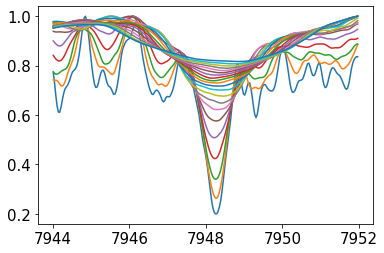

In [584]:
for row in specs:
    plt.plot(specs.index, specs[row]/specs[row].max())

In [619]:
sp = copy.deepcopy(sp2)

# Optionally mask a region in the SALT spectrum
sp = sp[(sp.lambd<7949) | (sp.lambd>7950)]

# plt.plot(sp.lambd, sp.flux + .002, c="k")
# g = Gaussian1DKernel(stddev=1)
# sp['flux'] = convolve(sp.flux, g)
# plt.plot(sp.lambd, sp.flux)
# plt.xlim(wavmin, wavmax)
# plt.ylim(0.003,0.0091)

In [620]:
def squared_diff(x):
    offset, amplitude, offy, vsini = x
    modelflux = broaden.rotational_convolution(wav, model.lambd, model.flux, vsini, epsilon=.8)
    mflux = modelflux / np.max(modelflux)
    sflux = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"flux"].values
    swav = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"lambd"].values + offset
    f = interpolate.interp1d(swav, sflux, fill_value="extrapolate")
    sfluxinterp = f(wav)
    sfluxinterp = amplitude * sfluxinterp / np.max(sfluxinterp) +  offy
    
    return ((mflux-sfluxinterp)**2).sum()

In [621]:
res = minimize(squared_diff, [(.1, .5, .1, 60.)], method='Powell', tol=1e-1)


100%|██████████| 241/241 [00:01<00:00, 149.27it/s]

100%|██████████| 241/241 [00:00<00:00, 542.80it/s]

100%|██████████| 241/241 [00:00<00:00, 514.39it/s]

100%|██████████| 241/241 [00:00<00:00, 540.80it/s]

100%|██████████| 241/241 [00:00<00:00, 545.33it/s]

100%|██████████| 241/241 [00:00<00:00, 522.48it/s]

100%|██████████| 241/241 [00:00<00:00, 555.08it/s]

100%|██████████| 241/241 [00:00<00:00, 494.31it/s]

100%|██████████| 241/241 [00:00<00:00, 456.31it/s]

100%|██████████| 241/241 [00:00<00:00, 515.80it/s]

100%|██████████| 241/241 [00:00<00:00, 513.60it/s]

100%|██████████| 241/241 [00:00<00:00, 542.95it/s]

100%|██████████| 241/241 [00:00<00:00, 570.76it/s]

100%|██████████| 241/241 [00:00<00:00, 535.83it/s]

100%|██████████| 241/241 [00:00<00:00, 527.98it/s]

100%|██████████| 241/241 [00:00<00:00, 559.86it/s]

100%|██████████| 241/241 [00:00<00:00, 583.68it/s]

100%|██████████| 241/241 [00:00<00:00, 529.29it/s]

100%|██████████| 241/241 [00:00<00:00, 519.19it/s]

100%|██████

100%|██████████| 241/241 [00:00<00:00, 526.96it/s]

100%|██████████| 241/241 [00:00<00:00, 587.29it/s]

100%|██████████| 241/241 [00:00<00:00, 509.05it/s]

100%|██████████| 241/241 [00:00<00:00, 563.00it/s]

100%|██████████| 241/241 [00:00<00:00, 576.30it/s]

100%|██████████| 241/241 [00:00<00:00, 580.73it/s]

100%|██████████| 241/241 [00:00<00:00, 550.14it/s]

100%|██████████| 241/241 [00:00<00:00, 553.68it/s]

100%|██████████| 241/241 [00:00<00:00, 512.39it/s]

100%|██████████| 241/241 [00:00<00:00, 553.12it/s]

100%|██████████| 241/241 [00:00<00:00, 562.09it/s]

100%|██████████| 241/241 [00:00<00:00, 622.16it/s]

100%|██████████| 241/241 [00:00<00:00, 632.08it/s]

100%|██████████| 241/241 [00:00<00:00, 600.38it/s]

100%|██████████| 241/241 [00:00<00:00, 536.58it/s]

100%|██████████| 241/241 [00:00<00:00, 508.16it/s]

100%|██████████| 241/241 [00:00<00:00, 561.89it/s]

100%|██████████| 241/241 [00:00<00:00, 507.93it/s]

100%|██████████| 241/241 [00:00<00:00, 546.57it/s]

100%|███████

100%|██████████| 241/241 [00:00<00:00, 569.65it/s]

100%|██████████| 241/241 [00:00<00:00, 375.21it/s]

100%|██████████| 241/241 [00:00<00:00, 506.33it/s]

100%|██████████| 241/241 [00:00<00:00, 511.67it/s]

100%|██████████| 241/241 [00:00<00:00, 453.12it/s]

100%|██████████| 241/241 [00:00<00:00, 525.09it/s]

100%|██████████| 241/241 [00:00<00:00, 550.09it/s]

100%|██████████| 241/241 [00:00<00:00, 544.51it/s]

100%|██████████| 241/241 [00:00<00:00, 519.77it/s]

100%|██████████| 241/241 [00:00<00:00, 529.14it/s]

100%|██████████| 241/241 [00:00<00:00, 549.05it/s]

100%|██████████| 241/241 [00:00<00:00, 597.57it/s]

100%|██████████| 241/241 [00:00<00:00, 566.05it/s]


In [611]:
res.x

array([0.33230791, 0.64343408, 0.27699839])

In [618]:
offset, amplitude, offy, vsini = res.x
offset

ValueError: not enough values to unpack (expected 4, got 3)

In [613]:
modelflux = broaden.rotational_convolution(wav, model.lambd, model.flux, vsini, epsilon=.8)
mflux = modelflux / np.max(modelflux)
sflux = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"flux"].values
swav = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"lambd"].values + offset
f = interpolate.interp1d(swav, sflux, fill_value="extrapolate")
sfluxinterp = f(wav)
sfluxinterp = amplitude * sfluxinterp / np.max(sfluxinterp) + offy

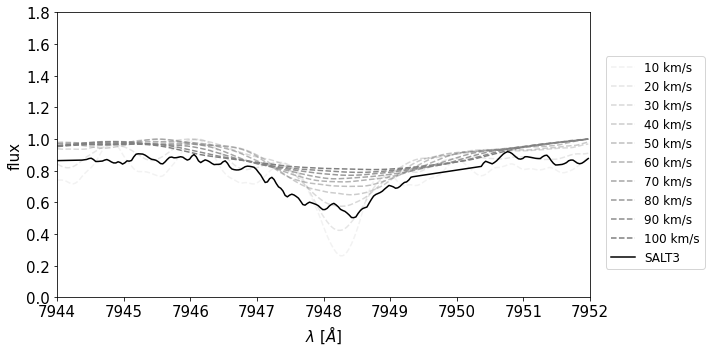

In [617]:
plt.figure(figsize=(10,5))
for spec in specs:
    if float(spec)%10 == 0:
        modelflux = specs[spec]
        mflux = modelflux / np.max(modelflux)
        plt.plot(wav, mflux, alpha=float(spec)/100, 
                 c="grey", linestyle="dashed", label=f"{spec} km/s")
        #plt.plot(wav, mflux - sfluxinterp-.2)
plt.plot(wav, sfluxinterp, c="k", label="SALT3")    
#gauss = gaussian(wav,6562.8,.6)+.3 + .6*gaussian(wav,6562.8,1.8)
#maxim = np.max(gauss)
#plt.plot(wav,gauss/maxim, label="double Gaussian" )
#lr = lorentz(wav,6562.8,2.) +.18
#plt.plot(wav,lr/np.max(lr),label="Lorentz profile")
plt.xlabel(r"$\lambda$ [$\AA$]", fontsize=15)
plt.ylabel(r"flux", fontsize=15)
plt.ylim(0,1.8)
plt.legend(loc=(1.03,.1), fontsize=12)
plt.xlim(wavmin, wavmax)
plt.tight_layout()
#plt.savefig("../plots/vsini/.png", dpi=300)

41.38 km /s

In [45]:
# convert wavelength to difference in velocity
l0 = wav[int(len(wav)/2)]
v = ((wav-l0)/wav * c).to("km/s")

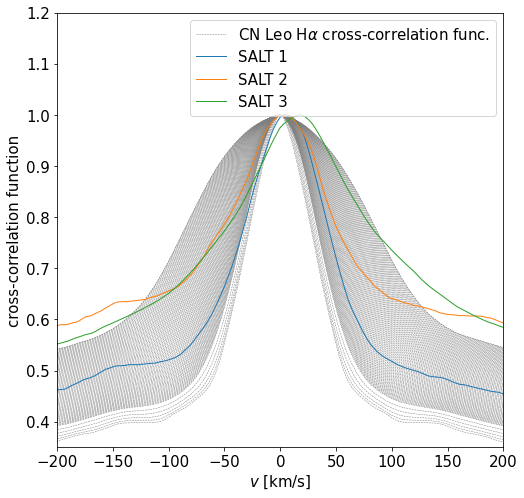

In [46]:
corrf = pd.DataFrame({"v":v})
plt.figure(figsize=(8,8))

for vsini, broad_spectrum in zip(vsinis, specs):
    # Convolve data
    if vsini>0:
        corr = correlate(specs[broad_spectrum],mflux, mode="same")
        me = np.max(corr)
        corrf[vsini] = corr/me
        plt.plot(v, corr/me, c="grey", linewidth=0.5,linestyle="dashed")#,label=f"{vsini} km/s")
plt.plot(v, corr/me, c="grey", linewidth=0.5,linestyle="dashed",label=r"CN Leo H$\alpha$ cross-correlation func.")
# corr = correlate(mflux,mflux, mode="same")
# me = np.max(corr)
# plt.plot(v,corr/me, c="grey", linewidth=0.5,label=f"0 km/s")
for sp, num in [(sp1,"1"), (sp2,"2"), (sp3,"3")]:#,sp4]:
    sflux = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"flux"].values
    swav = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"lambd"].values
    f = interpolate.interp1d(swav, sflux, fill_value="extrapolate")
    sfluxinterp = f(wav)
    sfluxinterp = sfluxinterp / np.max(sfluxinterp)
    
#     corr = correlate(mflux,sfluxinterp, mode="same")
#     me = np.max(corr)
#     corrf["salt"] = corr/me
#     print(np.max(sfluxinterp),np.max(mflux), np.max(corr))
#     plt.plot(v-45*u.km/u.s,corr/me, label=f"SALT", c="r", linewidth=1)
    
    corr = correlate(sfluxinterp,mflux, mode="same")
    me = np.max(corr)
    corrf["salt" + num] = corr/me
#    print(np.max(sfluxinterp),np.max(mflux), np.max(corr))
    plt.plot(v,corr/me, label=f"SALT {num}", linewidth=1)
w = 200
plt.xlim(-w,w)
plt.ylim(0.35,1.2)
plt.xlabel(r"$v$ [km/s]", fontsize=15)
plt.ylabel("cross-correlation function", fontsize=15)
plt.legend(fontsize=15)
#plt.savefig("../plots/vsini/CNleo_Halpha_cross_corr.png", dpi=300)

In [256]:
#corrf = corrf[(corrf.v>-1180) & (corrf.v<1180)]
corrf = corrf.set_index("v")

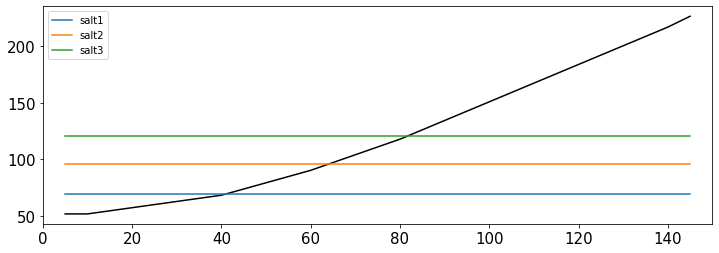

In [259]:
thresh=0.8
plt.figure(figsize=(12,4))
FWHM = corrf.apply(lambda x:x.index[np.where(x>thresh)[0][-1]]-x.index[np.where(x>thresh)[0][0]], axis=0)
plt.plot(FWHM.index[:-3],FWHM.values[:-3], c="k")
for i in [-3,-2,-1]:
    plt.plot([FWHM.index[0],FWHM.index[-4]],[FWHM.values[i]]*2, label=FWHM.index[i])
plt.xlim(0,150)
plt.legend()

Rough first estimates:  

- 45 km/s, 81 km/s, 103 km/s (thresh 0.7)
- 47 km/s, 115 km/s, 118 km/s (thresh 0.65)

In [258]:
FWHM

5         79.469945
10        82.210525
15        84.951128
20        87.691756
25        90.432410
30        95.913794
35       101.395278
40       106.876845
45       112.358479
50       120.581017
55       128.803605
60       137.026186
65       147.989510
70       157.572300
75       168.534295
80       179.495762
85       190.456561
90       202.799502
95       213.759602
100      227.459128
105      238.418471
110      250.763582
115      261.186221
120      270.719109
125      279.376365
130      288.908375
135      298.437465
140      306.555908
145      316.078153
salt1    115.142210
salt2    263.715827
salt3    269.604360
dtype: float64